# Data Pipeline - South Dakota Business Reviews Analysis

This notebook processes South Dakota business review data and metadata, performing data cleaning and preparation for analysis.

## 1. Import Required Libraries

Import the necessary libraries for data processing and analysis.

In [4]:
import gzip, json
import pandas as pd
from tabulate import tabulate
from typing import Dict, List
from pydantic import BaseModel
import time

## 2. Helper Functions

Define utility functions for parsing compressed JSON data.

In [5]:
def parse(path):
    """Parse gzipped JSON lines file and yield JSON objects."""
    with gzip.open(path, "rt", encoding="utf-8") as g:
        for line in g:
            yield json.loads(line)

## 3. Data Loading

Load the review data and business metadata from compressed JSON files.

In [6]:
# Load data from compressed JSON files
reviews_data = pd.read_json(
    "review_South_Dakota.json.gz", lines=True, compression="gzip"
)  # or .json/.parquet
biz_meta = pd.read_json("meta_South_Dakota.json.gz", lines=True, compression="gzip")

print(f"Reviews data shape: {reviews_data.shape}")
print(f"Business metadata shape: {biz_meta.shape}")

Reviews data shape: (673048, 8)
Business metadata shape: (14257, 15)


## 4. Data Standardization

Standardize column names for consistency.

In [7]:
# Standardize column names
biz_meta.columns = biz_meta.columns.str.lower().str.strip()
reviews_data.columns = reviews_data.columns.str.lower().str.strip()

print("Reviews data columns:", list(reviews_data.columns))
print("Business metadata columns:", list(biz_meta.columns))

Reviews data columns: ['user_id', 'name', 'time', 'rating', 'text', 'pics', 'resp', 'gmap_id']
Business metadata columns: ['name', 'address', 'gmap_id', 'description', 'latitude', 'longitude', 'category', 'avg_rating', 'num_of_reviews', 'price', 'hours', 'misc', 'state', 'relative_results', 'url']


## 5. Data Preview

Display the first few rows of both datasets to understand the data structure.

In [8]:
print("\nBusiness Metadata Sample:")
print(tabulate(biz_meta.head(20), headers="keys", tablefmt="psql"))


Business Metadata Sample:
+----+--------------------------------------+--------------------------------------------------------------------------------------------+---------------------------------------+---------------+------------+-------------+--------------------------------------------------------------------------------------------------------------------------------+--------------+------------------+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+----------------------------------------------------------

In [9]:
# Count missing per column
counts = reviews_data.isna().sum()
# Percent missing
percent = (reviews_data.isna().mean() * 100).round(2)
summary = pd.concat([counts.rename("missing_count"), percent.rename("missing_pct")], axis=1)
summary = summary.sort_values("missing_count", ascending=False)
print(f"\nMissing summary for reviews_data (n_rows={len(reviews_data)}):")
display(summary)   # if in notebook


# Remove reviews with missing essential columns
print(f"Reviews before cleaning: {len(reviews_data)}")
reviews_data = reviews_data.dropna(subset=["rating", "time", "gmap_id"])
print(f"Reviews after cleaning: {len(reviews_data)}")



# Create boolean feature for pictures
reviews_data["has_pics"] = reviews_data["pics"].notna()
print(f"Reviews with pictures: {reviews_data['has_pics'].sum()}")


Missing summary for reviews_data (n_rows=673048):


,missing_count,missing_pct
pics,657233,97.65
resp,589840,87.64
text,325966,48.43
user_id,0,0.00
rating,0,0.00
time,0,0.00
name,0,0.00
gmap_id,0,0.00


Reviews before cleaning: 673048
Reviews after cleaning: 673048
Reviews with pictures: 15815


In [10]:
# Remove businesses without gmap_id
print(f"Businesses before cleaning: {len(biz_meta)}")
biz_meta = biz_meta.dropna(subset=["gmap_id"])
print(f"Businesses after cleaning: {len(biz_meta)}")

# Convert price symbols to numeric levels ($ → 1, $$ → 2, etc.)
biz_meta["price_level"] = biz_meta["price"].str.len()
# Fill missing with 0 = unknown
biz_meta["price_level"] = biz_meta["price_level"].fillna(0).astype("int8")

print("Price level distribution:")
print(biz_meta["price_level"].value_counts().sort_index())

Businesses before cleaning: 14257
Businesses after cleaning: 14257
Price level distribution:
price_level
0    12021
1     1147
2     1050
3       38
4        1
Name: count, dtype: int64


In [11]:
# Define columns to keep for merging
keep_cols = [
    "gmap_id",  # join key
    "name",  # business name
    "category",  # type of business
    "avg_rating",  # business-level avg
    "num_of_reviews",  # business popularity
    "latitude",
    "longitude",  # optional
    "state",  # active/closed
]

# Filter to only existing columns
keep_cols = [c for c in keep_cols if c in biz_meta.columns]
print(f"Columns to keep: {keep_cols}")

# Create filtered metadata dataset
meta_small = biz_meta[keep_cols].drop_duplicates(subset=["gmap_id"]).copy()
print(f"Unique businesses in metadata: {len(meta_small)}")

Columns to keep: ['gmap_id', 'name', 'category', 'avg_rating', 'num_of_reviews', 'latitude', 'longitude', 'state']
Unique businesses in metadata: 14167


## Data Summary

Understand the merged data

In [12]:
print("Final Data Summary:")
print(f"- Reviews data: {reviews_data.shape}")
print(f"- Business metadata: {meta_small.shape}")
print(f"- Unique businesses with reviews: {reviews_data['gmap_id'].nunique()}")
print(f"- Average rating: {reviews_data['rating'].mean():.2f}")
print(f"- Reviews with pictures: {reviews_data['has_pics'].sum()} ({reviews_data['has_pics'].mean()*100:.1f}%)")

print("\nTable after cleaning:")
print(tabulate(reviews_data.head(20), headers="keys", tablefmt="psql"))

Final Data Summary:
- Reviews data: (673048, 9)
- Business metadata: (14167, 8)
- Unique businesses with reviews: 7255
- Average rating: 4.33
- Reviews with pictures: 15815 (2.3%)

Table after cleaning:
+----+-------------+-----------------------+---------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+--------+---------------------------------------+------------+
|    |     user_id | name                  |          time |   rating | text                                                                                                                                                                                                                   | pics   | resp   | gmap_id                               | has_pics   |
|----+-------------+-----------------------+---------------+----------+------

In [13]:
# Merge reviews with business metadata
merged_data = reviews_data.merge(meta_small, on="gmap_id", how="inner")
print(f"\nMerged data shape: {merged_data.shape}")

print("Merged Data Sample:")
print(tabulate(merged_data.head(20), headers="keys", tablefmt="psql"))
print(merged_data.info())



Merged data shape: (673048, 16)
Merged Data Sample:
+----+-------------+-----------------------+---------------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------+--------+---------------------------------------+------------+------------------------------+----------------------------------------+--------------+------------------+------------+-------------+--------------------+
|    |     user_id | name_x                |          time |   rating | text                                                                                                                                                                                                                   | pics   | resp   | gmap_id                               | has_pics   | name_y                       | category                               |  

## Text classification with LLM (e.g., OpenAI GPT-4)

Will remove non text rows from dataset and classify reviews into categories such as complaint, praise, suggestion, etc.

In [14]:
# Remove reviews with no text

print(f"Reviews before removing non-text: {len(merged_data)}")

# Soft filter: keep rows where 'text' is not null/empty after stripping whitespace
merged_data_og = merged_data.copy()
md_wtext = merged_data[merged_data["text"].str.strip().astype(bool)]

print(f"Reviews after removing non-text: {len(md_wtext)}")

print(md_wtext.info())

print(tabulate(md_wtext.head(20), headers="keys", tablefmt="psql"))
# print(md_wtext.head(20).index)

md_wtext["token_count"] = md_wtext["text"].apply(lambda x: len(str(x).split()))
total_tokens = md_wtext["token_count"].sum()
print(f"Total tokens in text reviews: {total_tokens}")


Reviews before removing non-text: 673048
Reviews after removing non-text: 347082
<class 'pandas.core.frame.DataFrame'>
Index: 347082 entries, 0 to 673041
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         347082 non-null  float64
 1   name_x          347082 non-null  object 
 2   time            347082 non-null  int64  
 3   rating          347082 non-null  int64  
 4   text            347082 non-null  object 
 5   pics            14238 non-null   object 
 6   resp            49330 non-null   object 
 7   gmap_id         347082 non-null  object 
 8   has_pics        347082 non-null  bool   
 9   name_y          347082 non-null  object 
 10  category        347002 non-null  object 
 11  avg_rating      347082 non-null  float64
 12  num_of_reviews  347082 non-null  int64  
 13  latitude        347082 non-null  float64
 14  longitude       347082 non-null  float64
 15  state           214448 non

C:\Users\yusia\AppData\Local\Temp\ipykernel_50384\67534025.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  md_wtext["token_count"] = md_wtext["text"].apply(lambda x: len(str(x).split()))


0                                                      None
1                                                      None
2                                                      None
6                      [Youth social services organization]
7                      [Youth social services organization]
                                ...                        
673037    [Winery, Brewery, Restaurant, Tourist attraction]
673038    [Winery, Brewery, Restaurant, Tourist attraction]
673039    [Winery, Brewery, Restaurant, Tourist attraction]
673040    [Winery, Brewery, Restaurant, Tourist attraction]
673041    [Winery, Brewery, Restaurant, Tourist attraction]
Name: category, Length: 347082, dtype: object


In [15]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import openai

load_dotenv()  # take environment variables from .env file


True

Create ReviewClassifier class to handle classification using LLM.

In [ ]:


class ReviewSchema(BaseModel):
    advertisement: bool
    advertisement_confidence_score: float
    irrelevant: bool
    irrelevant_confidence_score: float
    fake_rant: bool
    fake_rant_confidence_score: float


class ReviewClassifier():
    def __init__(self, api_key, isLocalLLM, model_name):
        self.api_key = api_key
        self.isLocalLLM = isLocalLLM
        self.modelName = model_name
        if isLocalLLM:
            self.client = OpenAI(api_key="lm_studio", base_url="http://localhost:1234/v1")  # Placeholder for local LLM client
        else:
            self.client = OpenAI(api_key=api_key)

    def getModelName(self):
        return self.modelName

    def classify_review(self, review_text, business_name, business_category) -> dict:
        """
        Classify a single review for policy violations using OpenAI API
        """
        
        prompt = f"""
                    You are a review moderator. Analyze this review for policy violations:

                    Review given by user: "{review_text}"
                    For Business name: "{business_name}"
                    Under Business category: "{business_category}"

                    Check for these violations strictly:
                    1. ADVERTISEMENT: Contains promotional content, links, phone numbers, or marketing
                    Positive Example: "Check out our website for more info!"
                    Negative Example: "Great food and service!"

                    2. IRRELEVANT: Not about the business (talks about personal life, politics, etc.) / off-topic / illegible texts
                    Positive Example: "I love hiking in the nearby mountains." / "sds fsdaf as"
                    Negative Example: "The pizza here is fantastic!"

                    3. FAKE_RANT: Negative review from someone who clearly never visited
                    Positive Example: "This place is a disaster, I would never go back!" (when evidence shows they never visited)
                    Negative Example: "I had a bad experience, but I might give it another try."

                    For each violation type, respond with true/false and a confidence score (0.0-1.0).
                    0.0: Very unlikely
                    1.0: Very sure it's true

                    Respond in JSON format like this:
                    {{
                        "advertisement": true/false,
                        "advertisement_confidence_score": float (0.0-1.0),
                        "irrelevant": true/false,
                        "irrelevant_confidence_score": float (0.0-1.0),
                        "fake_rant": true/false,
                        "fake_rant_confidence_score": float (0.0-1.0)
                    }}
                    Only respond with the JSON object, no extra text.
                    """
        
        review_schema = {
                "type": "json_schema",
                "json_schema": {
                    "name": "classify_review",
                    "schema": {
                        "type": "object",
                        "properties": {
                                "advertisement": {"type": "boolean", "description": "True if the review is an advertisement"},
                                "advertisement_confidence_score": {"type": "number", "description": "Confidence level for advertisement classification (0-1)"},
                                "irrelevant": {"type": "boolean", "description": "True if the review is irrelevant"},
                                "irrelevant_confidence_score": {"type": "number", "description": "Confidence level for irrelevant classification (0-1)"},
                                "fake_rant": {"type": "boolean", "description": "True if the review is a fake rant"},
                                "fake_rant_confidence_score": {"type": "number", "description": "Confidence level for fake rant classification (0-1)"}
                            },
                        "required": ["advertisement", "advertisement_confidence_score", "irrelevant", "irrelevant_confidence_score", "fake_rant", "fake_rant_confidence_score"]
                    }
                }
            }

        try:
            if (not self.isLocalLLM):
                print("Using ChatGPT model for classification")
                response = self.client.beta.chat.completions.parse(
                model=self.modelName,
                messages=[
                    {"role": "user", "content": prompt}
                ],
                # temperature=0.1,
                max_completion_tokens=1000,
                tools=[openai.pydantic_function_tool(ReviewSchema)],
                response_format=ReviewSchema
                # tools=[{
                #     "type": "function",
                #     "function": {
                #         "name": "classify_review",
                #         "description": "Classify review for policy violations",
                #         "parameters": {
                #             "type": "object",
                #             "properties": {
                #                 "advertisement": {"type": "boolean", "description": "True if the review is an advertisement"},
                #                 "advertisement_confidence": {"type": "number", "description": "Confidence level for advertisement classification (0-1)"},
                #                 "irrelevant": {"type": "boolean", "description": "True if the review is irrelevant"},
                #                 "irrelevant_confidence": {"type": "number", "description": "Confidence level for irrelevant classification (0-1)"},
                #                 "fake_rant": {"type": "boolean", "description": "True if the review is a fake rant"},
                #                 "fake_rant_confidence": {"type": "number", "description": "Confidence level for fake rant classification (0-1)"}
                #             },
                #             "required": ["advertisement", "advertisement_confidence", "irrelevant", "irrelevant_confidence", "fake_rant", "fake_rant_confidence"]
                #         }
                #     }
                # }]
            )

            else:
                print("Using local model for classification")
              

                response = self.client.chat.completions.create(
                    model=self.modelName,
                    messages=[
                        {"role": "user", "content": prompt}
                    ],
                    temperature=0.1,
                    max_tokens=500,
                    response_format=review_schema # type: ignore
                    )
            
            # Parse the JSON response
            print(f"response: ", response)
            result_text = response.choices[0].message.content
            result = json.loads(result_text) if result_text else {}
            
            
            return {
                'advertisement': result.get('advertisement', False),
                'advertisement_confidence_score': result.get('advertisement_confidence_score', 0.0),
                'irrelevant': result.get('irrelevant', False),
                'irrelevant_confidence_score': result.get('irrelevant_confidence_score', 0.0),
                'fake_rant': result.get('fake_rant', False),
                'fake_rant_confidence_score': result.get('fake_rant_confidence_score', 0.0)
            }
            
        except Exception as e:
            print(f"Error classifying review: {e}")
            return {
                'advertisement': False,
                'irrelevant': False,
                'fake_rant': False
            }
            

classifier = ReviewClassifier(api_key=os.getenv('OPENAI_API_KEY') or "", isLocalLLM=False, model_name="gpt-5-nano")

qwen14b: 2 min 40 sec for 100 reviews  
qwen4b: 1 min 5 sec for 100 reviews  
minimax: 1 min 45 sec for 100 reviews  

In [132]:
# Test the function on a few reviews
print("🧪 Testing classification function...")

# Get some sample reviews from your data
selected_data = md_wtext.head(2)

result_list = []

start_time = time.time()
for i, review in enumerate(selected_data['text']):
    print(f"\n--- Review {i+1} ---")
    print(f"Text: {review[:200]}...")

    result = classifier.classify_review(review_text=review, business_name=selected_data['name_y'].values[i],
                                         business_category=selected_data['category'].values[i])
    print(result)
    result_list.append(result)
    
    print(f"\nClassification Result {i+1}:")
    print(f"Advertisement: {'❌ YES' if result['advertisement'] else '✅ NO'}")
    print(f"Advertisement Confidence: {result.get('advertisement_confidence_score', 0.0):.2f}")
    print(f"Irrelevant: {'❌ YES' if result['irrelevant'] else '✅ NO'}")
    print(f"Irrelevant Confidence: {result.get('irrelevant_confidence_score', 0.0):.2f}")
    print(f"Fake Rant: {'❌ YES' if result['fake_rant'] else '✅ NO'}")
    print(f"Fake Rant Confidence: {result.get('fake_rant_confidence_score', 0.0):.2f}")

end_time = time.time()
time_taken = end_time - start_time

# Convert results to DataFrame
results_df = pd.DataFrame(result_list)

# Save results to CSV
results_df.to_csv(f"classification_results_{classifier.getModelName().replace('/', '-')}_{time_taken:2f}_{len(sample_reviews)}_{time.time()}.csv")

🧪 Testing classification function...

--- Review 1 ---
Text: Great place to care for our children....
Using ChatGPT model for classification
response:  ParsedChatCompletion[ReviewSchema](id='chatcmpl-C9YD85xS2N0YUglvgnXqlrL6J042d', choices=[ParsedChoice[ReviewSchema](finish_reason='stop', index=0, logprobs=None, message=ParsedChatCompletionMessage[ReviewSchema](content='{"advertisement": false, "advertisement_confidence_score": 0.12, "irrelevant": false, "irrelevant_confidence_score": 0.12, "fake_rant": false, "fake_rant_confidence_score": 0.12}', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None, parsed=ReviewSchema(advertisement=False, advertisement_confidence_score=0.12, irrelevant=False, irrelevant_confidence_score=0.12, fake_rant=False, fake_rant_confidence_score=0.12)))], created=1756392494, model='gpt-5-nano-2025-08-07', object='chat.completion', service_tier='default', system_fingerprint=None, usage=CompletionUsage(completion_tokens

In [ ]:
# --- Cell: Batch Classification Setup ---
import os, math, json, time
from pathlib import Path
from openai import OpenAI
from typing import Literal

class ReviewSchema(BaseModel):
    advertisement: bool
    advertisement_confidence_score: float
    irrelevant: bool
    irrelevant_confidence_score: float
    fake_rant: bool
    fake_rant_confidence_score: float


class BatchReviewClassifier:
    def __init__(self, api_key, model_name="gpt-5-nano", output_dir="batch_runs"):
        self.client = OpenAI(api_key=api_key)
        self.model_name = model_name
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
    def build_prompt(self, review_text: str, business_name: str, business_category: str) -> str:
        return f"""
            You are a strict review moderator. 
            
            Classify the following user review for policy violations based on the following context:
            Review:
            \"\"\"{review_text}\"\"\"
            Business Name: {business_name}
            Category: {business_category}

            Classify for:
            1. advertisement (link / phone / self-promo), do not flag positive customer praises, only business promotions
            2. irrelevant (off-topic, personal life, politics, gibberish, not related to business name / category)
            3. fake_rant (appears fabricated / unlikely real visit)

            Respond in JSON format like this:
            {{
            "advertisement": true/false,
            "advertisement_confidence_score": float (0-1),
            "irrelevant": true/false,
            "irrelevant_confidence_score": float (0-1),
            "fake_rant": true/false,
            "fake_rant_confidence_score": float (0-1)
            }}

            Rules:
            - No extra keys.
            - All confidence scores must be valid numbers 0–1.
            - If unsure -> choose false and confidence <= 0.4.
            - Never include commentary outside JSON.
            """.strip()

    def prepare_batch_file(self, df_source, max_rows_per_batch=50000, batch_prefix="batch"):
        """Prepare JSONL batch input files from DataFrame"""
        # Calculate batches needed
        total_rows = len(df_source)
        num_batches = math.ceil(total_rows / max_rows_per_batch)
        
        print(f"Preparing {total_rows} rows in {num_batches} batch file(s)")
        print(f"Max rows per batch: {max_rows_per_batch}")
        
        batch_files = []
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * max_rows_per_batch
            end_idx = min(start_idx + max_rows_per_batch, total_rows)
            chunk = df_source.iloc[start_idx:end_idx].copy()
            
            # Create batch input file
            timestamp = int(time.time())
            input_path = self.output_dir / f"{batch_prefix}_{batch_idx:03d}_{timestamp}.jsonl"
            
            with input_path.open("w", encoding="utf-8") as f:
                for idx, (orig_idx, row) in enumerate(chunk.iterrows()):
                    custom_id = f"review_{orig_idx}"  # Use original DataFrame index
                    
                    prompt_text = self.build_prompt(
                        review_text=str(row["text"]).strip()[:500],
                        business_name=str(row.get("name_y", "") or row.get("name", ""))[:50],
                        business_category=str(row.get("category", ""))[:30]
                    )
                    
                    body = {
                        "model": self.model_name,
                        # "temperature": 0.1,
                        "messages": [
                            # {"role": "system", "content": "You output ONLY valid JSON object per instructions."},
                            {"role": "user", "content": prompt_text}
                        ],
                     "response_format": {
                        "type": "json_schema",
                        "json_schema": {
                            "name": "review_classification",  # Required name field
                            "strict": True,  # Enable strict mode for better compliance
                            "schema": {
                                "type": "object",
                                "properties": {
                                    "advertisement": {
                                        "type": "boolean",
                                        "description": "True if the review is an advertisement"
                                    },
                                    "advertisement_confidence_score": {
                                        "type": "number",
                                        "description": "Confidence level for advertisement classification (0-1)"
                                    },
                                    "irrelevant": {
                                        "type": "boolean", 
                                        "description": "True if the review is irrelevant"
                                    },
                                    "irrelevant_confidence_score": {
                                        "type": "number",
                                        "description": "Confidence level for irrelevant classification (0-1)"
                                    },
                                    "fake_rant": {
                                        "type": "boolean",
                                        "description": "True if the review is a fake rant"
                                    },
                                    "fake_rant_confidence_score": {
                                        "type": "number",
                                        "description": "Confidence level for fake rant classification (0-1)"
                                    }
                                },
                                "required": [
                                    "advertisement", 
                                    "advertisement_confidence_score", 
                                    "irrelevant", 
                                    "irrelevant_confidence_score", 
                                    "fake_rant", 
                                    "fake_rant_confidence_score"
                                ],
                                "additionalProperties": False
                            }
                        }
                    },
                        "max_completion_tokens": 3000
                    }
                    
                    line_obj = {
                        "custom_id": custom_id,
                        "method": "POST",
                        "url": "/v1/chat/completions",
                        "body": body
                    }
                    f.write(json.dumps(line_obj) + "\n")
            
            batch_files.append(input_path)
            print(f"✅ Batch {batch_idx+1}/{num_batches}: {len(chunk)} rows -> {input_path.name}")
        
        return batch_files
        
    def submit_batch(self, input_file_path, completion_window: Literal['24h'] = "24h"):
        """Submit a single batch file to OpenAI"""
        print(f"📤 Uploading {input_file_path.name}...")

        with input_file_path.open("rb") as f:
            uploaded_file = self.client.files.create(file=f, purpose="batch")
        
        print(f"✅ File uploaded: {uploaded_file.id}")
        
        # Create batch job
        batch = self.client.batches.create(
            input_file_id=uploaded_file.id,
            endpoint="/v1/chat/completions",
            completion_window=completion_window
        )
        
        print(f"🚀 Batch created: {batch.id} (status: {batch.status})")
        return batch

    def submit_all_batches(self, batch_files, completion_window: Literal['24h'] = "24h"):
        """Submit batch files sequentially, waiting for each to complete before submitting the next"""
        completed_batches = []
        
        for i, file_path in enumerate(batch_files):
            try:
                print(f"\n🚀 Submitting batch {i+1}/{len(batch_files)}: {file_path.name}")
                
                # Submit the batch
                batch = self.submit_batch(file_path, completion_window)
                
                # Wait for this batch to complete before submitting the next
                print(f"⏳ Waiting for batch {batch.id} to complete before submitting next...")
                completed_batch = self.poll_single_batch(batch.id)
                completed_batches.append(completed_batch)
                
                print(f"✅ Batch {i+1}/{len(batch_files)} completed with status: {completed_batch.status}")
                
                # Small delay between batches
                time.sleep(2)
                
            except Exception as e:
                print(f"❌ Error with batch {file_path.name}: {e}")
                continue
        
        return completed_batches

    def poll_single_batch(self, batch_id, poll_interval=30):
        """Poll a single batch until completion"""
        while True:
            batch_status = self.check_batch_status(batch_id)
            print(f"🔄 Batch {batch_id}: {batch_status.status}")
            
            if batch_status.status in ["completed", "failed", "expired", "cancelled"]:
                return batch_status
            
            time.sleep(poll_interval) 

    def check_batch_status(self, batch_id):
        """Check status of a single batch"""
        return self.client.batches.retrieve(batch_id)
    
    def poll_all_batches(self, submitted_batches, poll_interval=30):
        """Poll all batches until completion"""
        pending_batches = submitted_batches.copy()
        completed_batches = []
        
        while pending_batches:
            print(f"\n🔄 Polling {len(pending_batches)} pending batches...")
            
            for batch_info in pending_batches.copy():
                batch_id = batch_info.id
                latest_batch = self.check_batch_status(batch_id)
                
                print(f"Batch {batch_id}: {latest_batch.status}")
                
                if latest_batch.status in ["completed", "failed", "expired", "cancelled"]:
                    completed_batches.append(latest_batch)
                    pending_batches.remove(batch_info)
            
            if pending_batches:
                print(f"⏳ Waiting {poll_interval}s before next check...")
                time.sleep(poll_interval)
        
        return completed_batches
    
    def download_and_parse_results(self, completed_batches):
        """Download and parse all batch results"""
        all_results = []
        
        for batch_info in completed_batches:
            batch_id = batch_info.id
            final_status = batch_info.status
            
            if final_status != "completed":
                print(f"⚠️ Skipping batch {batch_id} (status: {final_status.status})")
                continue
            
            if not batch_info.output_file_id:
                print(f"⚠️ No output file for batch {batch_id}")
                print(f" Error file contents: \n {self.client.files.content(batch_info.error_file_id).text}")
                continue
            
            # Download results
            print(f"📥 Downloading results for batch {batch_id}...")
            output_content = self.client.files.content(batch_info.output_file_id)

            # Save locally
            output_path = self.output_dir / f"{batch_id}_results.jsonl"
            with output_path.open("w", encoding="utf-8") as f:
                f.write(output_content.text)
            
            # Parse results
            batch_results = self.parse_batch_output(output_path)
            all_results.extend(batch_results)
            print(f"✅ Parsed {len(batch_results)} results from {batch_id}")
        
        return all_results
    
    def parse_batch_output(self, output_file_path):
        """Parse a single batch output file"""
        results = []
        
        with output_file_path.open("r", encoding="utf-8") as f:
            for line in f:
                try:
                    obj = json.loads(line.strip())
                    custom_id = obj.get("custom_id")
                    error = obj.get("error")
                    
                    if error:
                        # Error case - use defaults
                        result = {
                            "custom_id": custom_id,
                            "advertisement": False,
                            "advertisement_confidence_score": 0.0,
                            "irrelevant": False,
                            "irrelevant_confidence_score": 0.0,
                            "fake_rant": False,
                            "fake_rant_confidence_score": 0.0,
                            "error": str(error)
                        }
                    else:
                        # Success case - parse model response
                        response_body = obj.get("response", {}).get("body", {})
                        choices = response_body.get("choices", [])
                        
                        if choices:
                            content = choices[0]["message"]["content"]
                            parsed_content = self.parse_model_response(content)
                            
                            result = {
                                "custom_id": custom_id,
                                **parsed_content
                            }
                        else:
                            # No choices - use defaults
                            result = {
                                "custom_id": custom_id,
                                "advertisement": False,
                                "advertisement_confidence_score": 0.0,
                                "irrelevant": False,
                                "irrelevant_confidence_score": 0.0,
                                "fake_rant": False,
                                "fake_rant_confidence_score": 0.0,
                                "error": "No choices in response"
                            }
                    
                    results.append(result)
                    
                except Exception as e:
                    print(f"⚠️ Error parsing line: {e}")
                    continue
        
        return results
    
    def parse_model_response(self, content):
        """Parse model's JSON response with fallbacks"""
        try:
            # Try direct JSON parse
            data = json.loads(content)
        except:
            # Try extracting JSON from text
            try:
                start = content.find("{")
                end = content.rfind("}") + 1
                if start >= 0 and end > start:
                    data = json.loads(content[start:end])
                else:
                    raise ValueError("No JSON found")
            except:
                # Complete fallback
                data = {}
        
        # Ensure all required fields with defaults
        return {
            "advertisement": data.get("advertisement", False),
            "advertisement_confidence_score": float(data.get("advertisement_confidence_score", 0.0)),
            "irrelevant": data.get("irrelevant", False),
            "irrelevant_confidence_score": float(data.get("irrelevant_confidence_score", 0.0)),
            "fake_rant": data.get("fake_rant", False),
            "fake_rant_confidence_score": float(data.get("fake_rant_confidence_score", 0.0))
        }
    
    def process_full_dataset(self, df_source, max_rows_per_batch=50000, auto_poll=True):
        """Complete end-to-end batch processing with sequential submission"""
        print(f"🚀 Starting batch processing for {len(df_source)} rows")
        
        # Step 1: Prepare batch files
        batch_files = self.prepare_batch_file(df_source, max_rows_per_batch)
        
        # Step 2: Submit batches sequentially (each waits for previous to complete)
        print(f"📤 Submitting {len(batch_files)} batches sequentially to respect token limits...")
        completed_batches = self.submit_all_batches(batch_files)
        
        if not completed_batches:
            print("❌ No batches were successfully completed")
            return None
        
        print(f"✅ All {len(completed_batches)} batches completed!")
        
        # Step 3: Download and parse all results
        all_results = self.download_and_parse_results(completed_batches)
        
        # Step 4: Convert to DataFrame and merge
        results_df = pd.DataFrame(all_results)
        
        if len(results_df) > 0:
            # Extract original index from custom_id
            results_df["orig_index"] = results_df["custom_id"].str.replace("review_", "", regex=False).astype(int)
            
            # Merge back with original data
            final_df = self.merge_results_with_source(df_source, results_df)
            
            # Save results
            timestamp = int(time.time())
            output_file = f"classified_reviews_{self.model_name.replace('/', '-')}_{timestamp}.csv"
            final_df.to_csv(output_file, index=True)
            final_df.to_parquet(f"classified_reviews_{self.model_name.replace('/', '-')}_{timestamp}.parquet", index=True)
            
            print(f"🎉 Complete! Results saved to: {output_file}")
            print(f"📊 Processed: {len(final_df)} rows")
            print(f"✅ Success rate: {(len(results_df) / len(df_source) * 100):.1f}%")
            
            return final_df
        else:
            print("❌ No results obtained from batches")
            return None
    
    def merge_results_with_source(self, df_source, results_df):
        """Merge classification results back with source DataFrame"""
        # df_source already has its original index intact
        # We just need to merge on it directly
        
        # Ensure results_df has the original index properly extracted
        if "orig_index" not in results_df.columns:
            results_df["orig_index"] = results_df["custom_id"].str.replace("review_", "", regex=False).astype(int)
        
        # Create a copy of source with index as column for merging
        source_with_index = df_source.copy()
        source_with_index["orig_index"] = source_with_index.index
        
        # Merge on original index
        merged = source_with_index.merge(
            results_df[["orig_index", "advertisement", "advertisement_confidence_score", 
                    "irrelevant", "irrelevant_confidence_score", 
                    "fake_rant", "fake_rant_confidence_score"]], 
            on="orig_index", 
            how="left"
        )
        
        # Set the index back to the original index
        merged = merged.set_index("orig_index")
        merged.index.name = df_source.index.name  # Preserve original index name
        
        return merged
    
    

# Initialize the batch classifier
batch_classifier = BatchReviewClassifier(
    api_key=os.getenv('OPENAI_API_KEY'),
    model_name="gpt-5-nano",
    output_dir="batch_runs"
)

print("✅ Batch classifier initialized")
print(f"📊 Dataset ready: {len(md_wtext)} rows")

✅ Batch classifier initialized
📊 Dataset ready: 347082 rows


## --- Cell: Run Full Batch Processing ---


In [92]:
# --- Cell: Run Full Batch Processing ---

print("🚀 Processing all rows with automatic batch management...")

final_results = batch_classifier.process_full_dataset(
    df_source=md_wtext.head(10000),
    max_rows_per_batch=2500,  # OpenAI allows up to 50k requests per batch
    auto_poll=True  # Automatically wait for completion
)

if final_results is not None:
    print("\n📋 Classification Summary:")
    print(f"Total reviews: {len(final_results)}")
    print(f"Advertisements: {final_results['advertisement'].sum()}")
    print(f"Irrelevant: {final_results['irrelevant'].sum()}")
    print(f"Fake rants: {final_results['fake_rant'].sum()}")
    
    # Show sample results
    print("\n🔍 Sample Results:")
    sample_cols = ['text', 'advertisement', 'advertisement_confidence_score', 
                   'irrelevant', 'irrelevant_confidence_score', 
                   'fake_rant', 'fake_rant_confidence_score']
    print(tabulate(final_results[sample_cols].head(10), headers="keys", tablefmt="psql"))

🚀 Processing all rows with automatic batch management...
🚀 Starting batch processing for 10000 rows
Preparing 10000 rows in 4 batch file(s)
Max rows per batch: 2500
✅ Batch 1/4: 2500 rows -> batch_000_1756523834.jsonl
✅ Batch 2/4: 2500 rows -> batch_001_1756523834.jsonl
✅ Batch 3/4: 2500 rows -> batch_002_1756523834.jsonl
✅ Batch 4/4: 2500 rows -> batch_003_1756523834.jsonl
📤 Submitting 4 batches sequentially to respect token limits...

🚀 Submitting batch 1/4: batch_000_1756523834.jsonl
📤 Uploading batch_000_1756523834.jsonl...
✅ File uploaded: file-HM8Mp8pinjzB3y2R9X8TWh
🚀 Batch created: batch_68b26d3d2ef8819090f4fb7fdf884985 (status: validating)
⏳ Waiting for batch batch_68b26d3d2ef8819090f4fb7fdf884985 to complete before submitting next...
🔄 Batch batch_68b26d3d2ef8819090f4fb7fdf884985: validating
🔄 Batch batch_68b26d3d2ef8819090f4fb7fdf884985: validating
🔄 Batch batch_68b26d3d2ef8819090f4fb7fdf884985: validating
🔄 Batch batch_68b26d3d2ef8819090f4fb7fdf884985: in_progress
🔄 Batch ba

## EDA of flagged reviews

#### Advertisements

In [93]:
print("\n🔍 Advertisements:")

cols = ['name_y','category','text', 'advertisement', 'advertisement_confidence_score', 
                   'irrelevant', 'irrelevant_confidence_score', 
                   'fake_rant', 'fake_rant_confidence_score']
advertisement_df = final_results[final_results['advertisement'] == True]
print(tabulate(advertisement_df[cols].head(50), headers="keys", tablefmt="psql"))


🔍 Advertisements:
+------+-------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+----------------------------------+--------------+-------------------------------+-------------+------------------------------+
|      | name_y                                          | category      

#### Irrelevant

In [94]:
flagged_df = final_results[final_results['irrelevant'] == True]
print(tabulate(flagged_df[cols].head(50), headers="keys", tablefmt="psql"))

+------+-------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+----------------------------------+--------------+-------------------------------+-------------+------------------------------+
|      | name_y                                          | category                                                                                                                                                                                                         | text                                                                  

#### Fake Rants

In [95]:
flagged_df = final_results[final_results['fake_rant'] == True]
print(tabulate(flagged_df[cols].head(50), headers="keys", tablefmt="psql"))

+-------+-------------------+----------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+----------------------------------+--------------+-------------------------------+-------------+------------------------------+
|       | name_y            | category                                                             | text                                                                                                                                                                                                                                                                                       

🚀 Starting Comprehensive Analysis...
🔍 CLASSIFICATION STATISTICS
Total Reviews Analyzed: 10,000

ADVERTISEMENT:
  - Flagged: 145 reviews (1.45%)
  - Average Confidence: 0.513
  - Flagged Confidence Range: 0.600 - 0.930

IRRELEVANT:
  - Flagged: 285 reviews (2.85%)
  - Average Confidence: 0.552
  - Flagged Confidence Range: 0.250 - 0.920

FAKE_RANT:
  - Flagged: 4 reviews (0.04%)
  - Average Confidence: 0.472
  - Flagged Confidence Range: 0.650 - 0.900

📊 CONFIDENCE SCORE ANALYSIS


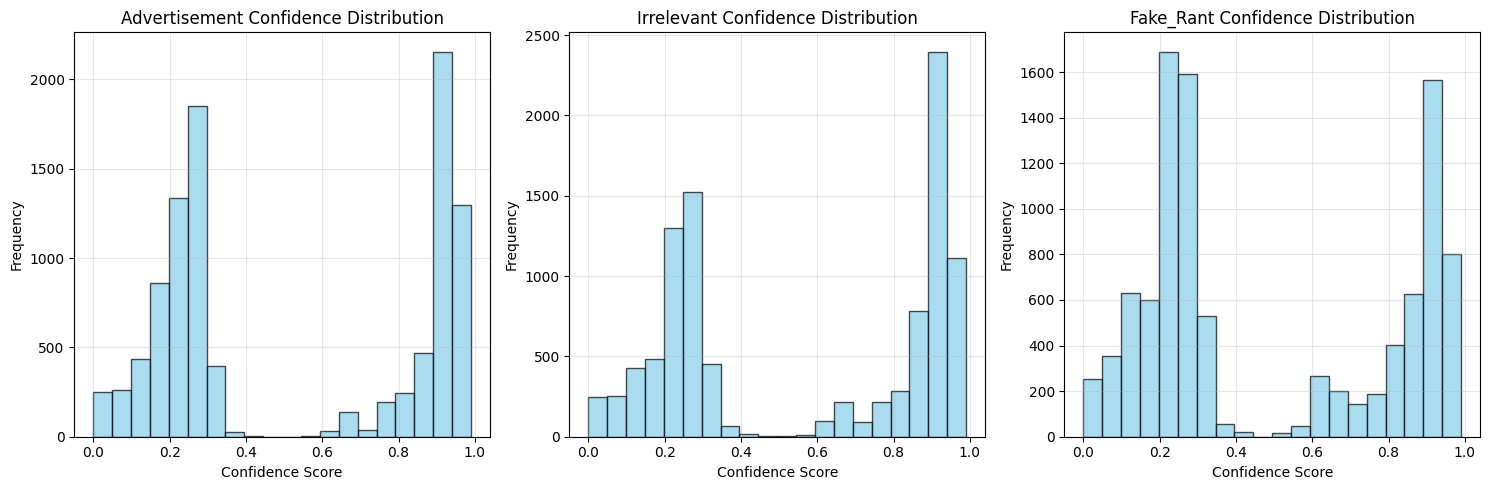


🎯 THRESHOLD SENSITIVITY ANALYSIS
+----+-------------+-----------------------+---------------------+--------------------+------------------+-------------------+-----------------+
|    |   threshold |   advertisement_count |   advertisement_pct |   irrelevant_count |   irrelevant_pct |   fake_rant_count |   fake_rant_pct |
|----+-------------+-----------------------+---------------------+--------------------+------------------+-------------------+-----------------|
|  0 |        0.10 |               9480.00 |               94.80 |            9490.00 |            94.90 |           9385.00 |           93.85 |
|  1 |        0.30 |               5000.00 |               50.00 |            5755.00 |            57.55 |           4871.00 |           48.71 |
|  2 |        0.50 |               4573.00 |               45.73 |            5212.00 |            52.12 |           4262.00 |           42.62 |
|  3 |        0.70 |               4397.00 |               43.97 |            4884.00 |         

In [ ]:
# --- Cell: Comprehensive Model Evaluation and Analysis ---

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

class ReviewAnalyzer:
    def __init__(self, results_df):
        self.results_df = results_df.copy()
        self.violation_types = ['advertisement', 'irrelevant', 'fake_rant']
    
    def basic_statistics(self):
        """Generate basic statistics about the classifications"""
        print("🔍 CLASSIFICATION STATISTICS")
        print("=" * 50)
        
        total_reviews = len(self.results_df)
        print(f"Total Reviews Analyzed: {total_reviews:,}")
        
        for violation_type in self.violation_types:
            if violation_type in self.results_df.columns:
                count = self.results_df[violation_type].sum()
                percentage = (count / total_reviews) * 100
                confidence_col = f"{violation_type}_confidence_score"
                avg_confidence = self.results_df[confidence_col].mean() if confidence_col in self.results_df.columns else 0
                
                print(f"\n{violation_type.upper()}:")
                print(f"  - Flagged: {count:,} reviews ({percentage:.2f}%)")
                print(f"  - Average Confidence: {avg_confidence:.3f}")
                
                # Confidence distribution for flagged items
                if count > 0:
                    flagged_confidence = self.results_df[self.results_df[violation_type] == True][confidence_col]
                    print(f"  - Flagged Confidence Range: {flagged_confidence.min():.3f} - {flagged_confidence.max():.3f}")
    
    def confidence_analysis(self):
        """Analyze confidence score distributions"""
        print("\n📊 CONFIDENCE SCORE ANALYSIS")
        print("=" * 50)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for i, violation_type in enumerate(self.violation_types):
            confidence_col = f"{violation_type}_confidence_score"
            if confidence_col in self.results_df.columns:
                # Plot confidence distribution
                axes[i].hist(self.results_df[confidence_col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
                axes[i].set_title(f'{violation_type.title()} Confidence Distribution')
                axes[i].set_xlabel('Confidence Score')
                axes[i].set_ylabel('Frequency')
                axes[i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def threshold_analysis(self, thresholds=[0.1, 0.3, 0.5, 0.7, 0.9]):
        """Analyze how different confidence thresholds affect classifications"""
        print("\n🎯 THRESHOLD SENSITIVITY ANALYSIS")
        print("=" * 50)
        
        threshold_results = []
        
        for threshold in thresholds:
            row = {'threshold': threshold}
            
            for violation_type in self.violation_types:
                confidence_col = f"{violation_type}_confidence_score"
                if confidence_col in self.results_df.columns:
                    # Count how many would be flagged at this threshold
                    flagged_at_threshold = (self.results_df[confidence_col] >= threshold).sum()
                    percentage = (flagged_at_threshold / len(self.results_df)) * 100
                    row[f"{violation_type}_count"] = flagged_at_threshold
                    row[f"{violation_type}_pct"] = percentage
            
            threshold_results.append(row)
        
        threshold_df = pd.DataFrame(threshold_results)
        print(tabulate(threshold_df, headers="keys", tablefmt="psql", floatfmt=".2f"))
        
        return threshold_df

    def export_results_summary(self):
        """Export comprehensive results summary"""
        timestamp = int(time.time())
        summary_file = f"evaluation_summary_{timestamp}.txt"
        
        with open(summary_file, 'w') as f:
            f.write("REVIEW CLASSIFICATION EVALUATION SUMMARY\n")
            f.write("=" * 50 + "\n\n")
            
            # Basic stats
            total = len(self.results_df)
            f.write(f"Total Reviews: {total:,}\n\n")
            
            for violation_type in self.violation_types:
                if violation_type in self.results_df.columns:
                    count = self.results_df[violation_type].sum()
                    pct = (count / total) * 100
                    f.write(f"{violation_type.upper()}: {count:,} ({pct:.2f}%)\n")
        
        print(f"📄 Results summary exported to: {summary_file}")

# Initialize analyzer with your results
analyzer = ReviewAnalyzer(final_results)

# Run comprehensive analysis
print("🚀 Starting Comprehensive Analysis...")
analyzer.basic_statistics()
analyzer.confidence_analysis()
threshold_df = analyzer.threshold_analysis()
# analyzer.inter_annotator_agreement()

# Create ground truth sample for manual evaluation
# sample_df, sample_file = analyzer.create_ground_truth_sample(sample_size=50)

# Export summary
analyzer.export_results_summary()